/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


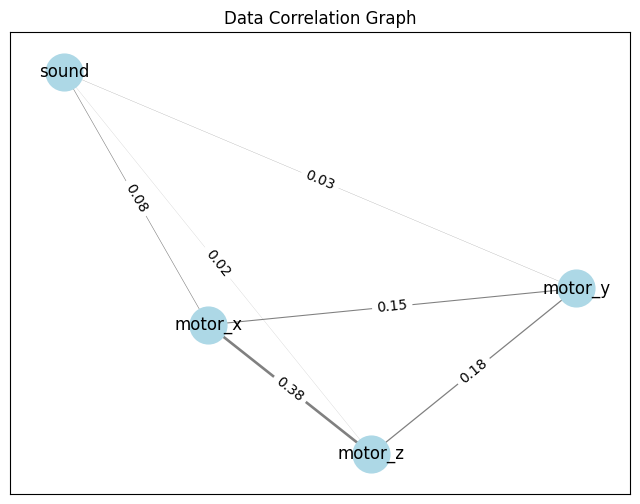

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 파일 경로 설정
normal_file_path = './csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_23.csv'

# CSV 파일 읽기
normal_df = pd.read_csv(normal_file_path)

# 상관 행렬 계산
corr_matrix = normal_df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']].corr().values

# 상관계수 임계값 설정
threshold = 0  # 임계값을 0으로 설정하여 모든 관계 포함
edges = np.where(np.abs(corr_matrix) > threshold)

# 노드 이름 설정
node_labels = ['motor_x', 'motor_y', 'motor_z', 'sound']

# 그래프 생성
G = nx.Graph()

# 노드 추가
for node in node_labels:
    G.add_node(node)

# 엣지 추가
for i in range(len(edges[0])):
    if edges[0][i] != edges[1][i]:  # 자기 자신과의 엣지 제외
        G.add_edge(node_labels[edges[0][i]], node_labels[edges[1][i]], weight=np.abs(corr_matrix[edges[0][i], edges[1][i]]))

# 그래프 시각화
pos = nx.spring_layout(G, seed=42)  # 노드 배치 설정
plt.figure(figsize=(8, 6))

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
# 엣지 그리기 (엣지 두께는 상관계수 크기에 비례)
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u,v in G.edges()])
# 라벨 그리기
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
# 엣지 라벨 그리기 (상관계수)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Data Correlation Graph")
plt.show()

/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 10, Loss: 1.1453
Epoch 20, Loss: 1.0264
Epoch 30, Loss: 0.9173
Epoch 40, Loss: 0.8969
Epoch 50, Loss: 0.8766
Epoch 60, Loss: 0.8635
Epoch 70, Loss: 0.8576
Epoch 80, Loss: 0.8556
Epoch 90, Loss: 0.8499
Epoch 100, Loss: 0.8455
Epoch 110, Loss: 0.8424
Epoch 120, Loss: 0.8355
Epoch 130, Loss: 0.8406
Epoch 140, Loss: 0.8333
Epoch 150, Loss: 0.8346
Epoch 160, Loss: 0.8321
Epoch 170, Loss: 0.8307
Epoch 180, Loss: 0.8291
Epoch 190, Loss: 0.8299
Epoch 200, Loss: 0.8287
Epoch 1/100, Train Loss: 0.6087, Validation Loss: 0.4409
Epoch 2/100, Train Loss: 0.4110, Validation Loss: 0.4171
Epoch 3/100, Train Loss: 0.3953, Validation Loss: 0.4143
Epoch 4/100, Train Loss: 0.3855, Validation Loss: 0.3995
Epoch 5/100, Train Loss: 0.3772, Validation Loss: 0.3994
Epoch 6/100, Train Loss: 0.3723, Validation Loss: 0.3939
Epoch 7/100, Train Loss: 0.3679, Validation Loss: 0.4004
Epoch 8/100, Train Loss: 0.3651, Validation Loss: 0.3887
Epoch 9/100, Train Loss: 0.3612, Validation Loss: 0.3908
Epoch 10/100, Tr

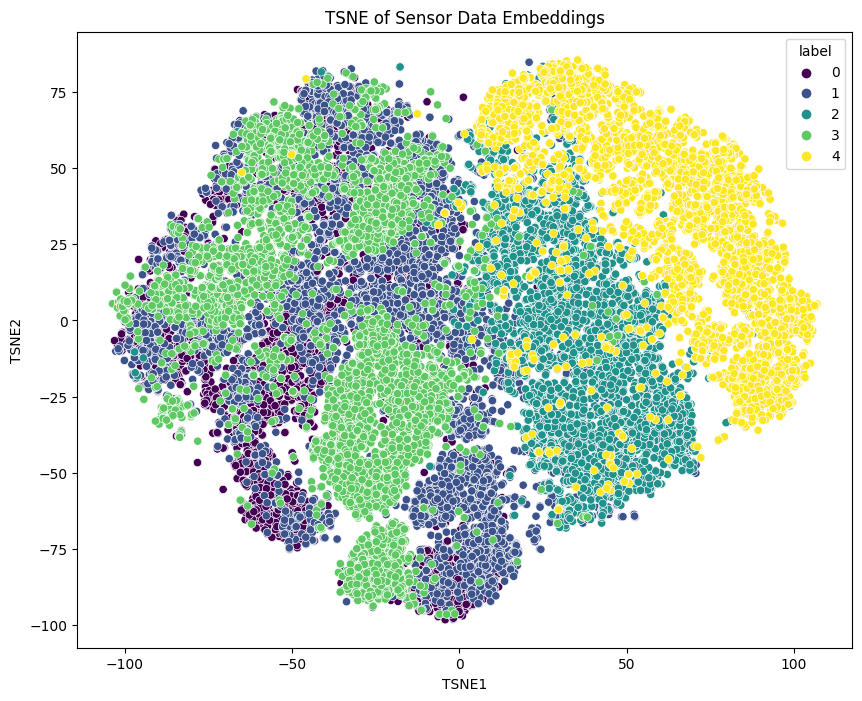

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import stft
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Step 1: 데이터 로드 및 정규화
def normalize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

def load_and_normalize_data(filenames, label):
    data_list = []
    for filename in filenames:
        df = pd.read_csv(filename)
        motor_data_normalized = normalize_data(df[['motor1_x', 'motor1_y', 'motor1_z']])
        sound_data_normalized = normalize_data(df[['sound']])
        data_list.append((motor_data_normalized, sound_data_normalized, label))
    return data_list

normal_files = ["./csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv"]
fault1_files = ["./csv/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv"]
fault2_files = ["./csv/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv"]
fault3_files = ["./csv/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv"]
fault4_files = ["./csv/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv"]

data_normal = load_and_normalize_data(normal_files, 0)
data_fault1 = load_and_normalize_data(fault1_files, 1)
data_fault2 = load_and_normalize_data(fault2_files, 2)
data_fault3 = load_and_normalize_data(fault3_files, 3)
data_fault4 = load_and_normalize_data(fault4_files, 4)

all_data = data_normal + data_fault1 + data_fault2 + data_fault3 + data_fault4

# Step 2: 상관행렬을 사용하여 그래프 생성
def create_graph_from_corr_matrix(df):
    corr_matrix = df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']].corr().values
    threshold = 0  # 임계값을 0으로 설정하여 모든 관계 포함
    edges = np.where(np.abs(corr_matrix) > threshold)
    node_labels = ['motor_x', 'motor_y', 'motor_z', 'sound']
    G = nx.Graph()
    for node in node_labels:
        G.add_node(node)
    for i in range(len(edges[0])):
        if edges[0][i] != edges[1][i]:
            G.add_edge(node_labels[edges[0][i]], node_labels[edges[1][i]], weight=np.abs(corr_matrix[edges[0][i], edges[1][i]]))
    return G

normal_df = pd.read_csv(normal_files[0])
G = create_graph_from_corr_matrix(normal_df)

# Step 3: 시계열 데이터를 윈도우로 분할 및 STFT 변환
def create_windows(data, window_size, stride):
    windows = []
    labels = []
    for (motor_data, sound_data, label) in data:
        combined_data = np.hstack([motor_data, sound_data])
        for i in range(0, len(combined_data) - window_size + 1, stride):
            window = combined_data[i:i + window_size, :]
            windows.append(window)
            labels.append(label)
    return np.array(windows), np.array(labels)

window_size = 100
stride = 50
features, labels = create_windows(all_data, window_size, stride)

def apply_stft(windows, nperseg=50):
    stft_windows = []
    for window in windows:
        stft_result = []
        for signal in window.T:
            f, t, Zxx = stft(signal, nperseg=min(len(signal), nperseg))
            stft_result.append(np.abs(Zxx))
        stft_windows.append(np.array(stft_result))
    return np.array(stft_windows)

stft_features = apply_stft(features)
stft_features = stft_features.transpose(0, 2, 1, 3)  # (samples, time, features)

# Step 4: 노드 특성 정규화 및 그래프 생성
scaler = StandardScaler()
features_scaled = scaler.fit_transform(stft_features.reshape(stft_features.shape[0], -1))

k = 5
knn = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)

edge_index = []
for i in range(indices.shape[0]):
    for j in range(1, k):
        edge_index.append([i, indices[i, j]])

edge_index = np.array(edge_index).T
x = torch.tensor(features_scaled, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)
data = train_test_split_edges(data)

class GraphVAE(VGAE):
    def __init__(self, in_channels, out_channels):
        encoder = torch.nn.ModuleList([
            GCNConv(in_channels, 16),
            GCNConv(16, out_channels)
        ])
        super(GraphVAE, self).__init__(encoder)
        self.conv1 = encoder[0]
        self.conv2 = encoder[1]
        self.__mu__ = None
        self.__logstd__ = None

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        self.__mu__ = self.conv2(x, edge_index)
        self.__logstd__ = torch.zeros_like(self.__mu__)
        return self.__mu__

in_channels = x.shape[1]
out_channels = 16
model = GraphVAE(in_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.test_pos_edge_index)

X = z.cpu().numpy()
y = labels

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: LSTM 모델 정의 및 학습
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h, _ = self.lstm(x)
        h = h[:, -1, :]
        out = self.fc(h)
        return out

input_dim = X_train.shape[1]
hidden_dim = 64
num_layers = 2
num_classes = len(np.unique(y))

model = LSTMClassifier(input_dim, hidden_dim, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    val_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), 1, input_dim)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), 1, input_dim)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Step 6: 모델 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), 1, input_dim)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')

# TSNE 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X)

df_embeddings = pd.DataFrame(embeddings_2d, columns=['TSNE1', 'TSNE2'])
df_embeddings['label'] = y

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeddings, x='TSNE1', y='TSNE2', hue='label', palette='viridis', legend='full')
plt.title("TSNE of Sensor Data Embeddings")
plt.show()
